Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2605949..0.9999999].


Predicted Class: monkey, Real/Fake Confidence: 0.4951


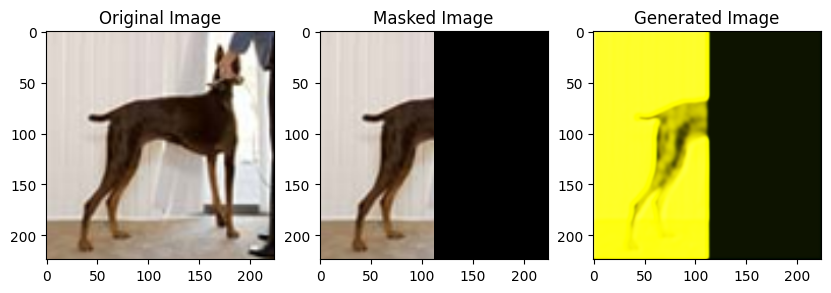

Predicted Class: dog, Real/Fake Confidence: 0.7670


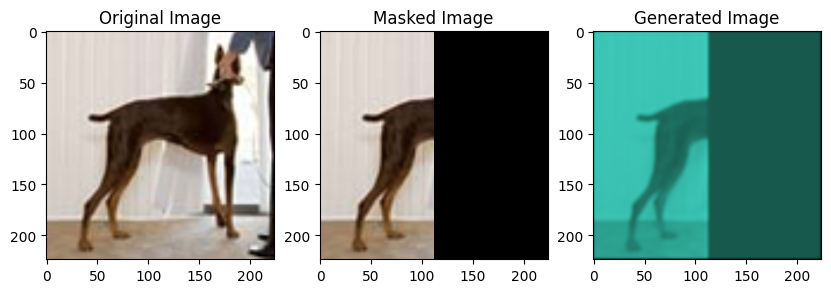

Predicted Class: truck, Real/Fake Confidence: 0.6269


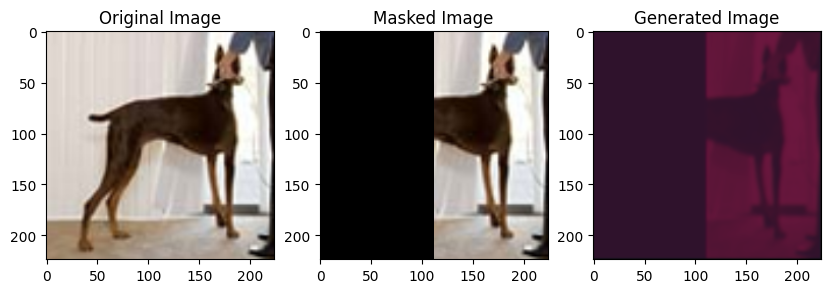

Predicted Class: airplane, Real/Fake Confidence: 0.5065


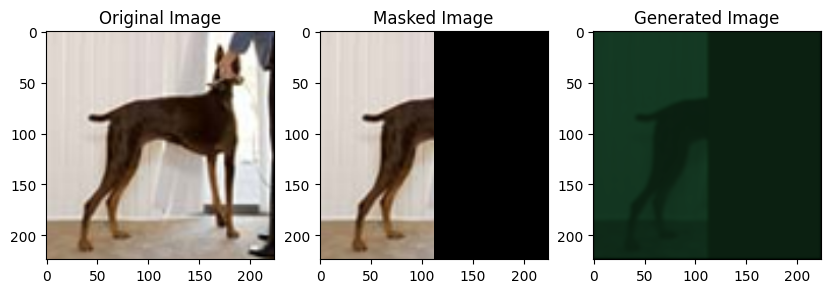

KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for input
    transforms.ToTensor(),
])

# Load STL-10 Dataset
SUBSET_RATIO = 0.2  # Define subset ratio
BATCH_SIZE = 8
EPOCHS = 5

full_dataset = datasets.STL10(root="./data", split="train", transform=transform, download=True)
subset_size = int(SUBSET_RATIO * len(full_dataset))  # Small subset for testing
indices = np.random.choice(len(full_dataset), subset_size, replace=False)
subset_dataset = Subset(full_dataset, indices)

# Split into Train (80%) & Test (20%)
train_size = int(0.8 * subset_size)
test_size = subset_size - train_size
train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey", "ship", "truck"
]

# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Downsample to 112x112
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # Downsample to 56x56
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output size: (512, 1, 1)
        )
        self.real_fake_head = nn.Linear(512, 1)  # Much smaller now!
        self.class_head = nn.Linear(512, 10)  # Multi-class classification
    
    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.shape[0], -1)  # Flatten
        real_fake = torch.sigmoid(self.real_fake_head(features))
        class_pred = self.class_head(features)  # No sigmoid for multi-class
        return real_fake, class_pred

# Loss functions
criterion_real_fake = nn.BCELoss()
criterion_class = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Function to apply half-image masking
def mask_half_image(image):
    _, h, w = image.shape
    masked_image = image.clone()
    left_or_right = np.random.choice([0, 1])
    if left_or_right == 0:
        masked_image[:, :, :w//2] = 0  # Mask left half with black pixels
    else:
        masked_image[:, :, w//2:] = 0  # Mask right half with black pixels
    return masked_image

# Training loop
for epoch in range(EPOCHS):
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    correct = 0
    total = 0
    
    for real_images, labels in progress_bar:
        real_images, labels = real_images.to(device), labels.to(device)
        
        # Apply masking instead of resizing
        masked_images = torch.stack([mask_half_image(img) for img in real_images]).to(device)
        fake_images = generator(masked_images)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        real_preds, real_class = discriminator(real_images)
        fake_preds, fake_class = discriminator(fake_images.detach())
        
        loss_real_fake = criterion_real_fake(real_preds, torch.ones_like(real_preds)) + \
                        criterion_real_fake(fake_preds, torch.zeros_like(fake_preds))
        loss_class = criterion_class(real_class, labels)
        loss_D = loss_real_fake + loss_class
        loss_D.backward()
        optimizer_D.step()
        
        # Train Generator
        optimizer_G.zero_grad()
        fake_preds, fake_class = discriminator(fake_images)
        loss_G = criterion_real_fake(fake_preds, torch.ones_like(fake_preds)) + criterion_class(fake_class, labels)
        loss_G.backward()
        optimizer_G.step()
        
        # Compute accuracy
        _, predicted = torch.max(real_class, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        progress_bar.set_postfix(Loss_D=loss_D.item(), Loss_G=loss_G.item(), Accuracy=100 * correct / total)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}, Accuracy: {100 * correct / total:.2f}%")
    
    # Visualization after each epoch
    real_images, labels = next(iter(test_dataloader))
    real_images = real_images.to(device)
    masked_image = mask_half_image(real_images[0]).to(device).unsqueeze(0)
    fake_image = generator(masked_image).squeeze(0)
    real_fake_pred, class_pred = discriminator(real_images[0].unsqueeze(0))
    predicted_class = torch.argmax(class_pred, dim=1).item()
    
    print(f"Predicted Class: {class_names[predicted_class]}, Real/Fake Confidence: {real_fake_pred.item():.4f}")
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(real_images[0].cpu().permute(1, 2, 0).numpy())
    plt.subplot(1, 3, 2)
    plt.title("Masked Image")
    plt.imshow(masked_image.squeeze(0).cpu().permute(1, 2, 0).numpy())
    plt.subplot(1, 3, 3)
    plt.title("Generated Image")
    plt.imshow(fake_image.cpu().permute(1, 2, 0).detach().numpy())
    plt.show()